### Variation 1: Negative Prompt

In [6]:
#导入包和加载组件

import torch, logging

## disable warnings
logging.disable(logging.WARNING)  

## Imaging  library
from PIL import Image
from torchvision import transforms as tfms

## Basic libraries
from fastdownload import FastDownload
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import shutil
import os

## For video display
from IPython.display import HTML
from base64 import b64encode


## Import the CLIP artifacts 
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

## Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained("pretrain_model/stable-diffusion-v1-4", subfolder="tokenizer", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("pretrain_model/stable-diffusion-v1-4", subfolder="text_encoder", torch_dtype=torch.float16).to("cuda")

## Initiating the VAE
vae = AutoencoderKL.from_pretrained("pretrain_model/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")

## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("pretrain_model/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

## Helper functions
def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

In [7]:
#负文本主要是改变空文本，把空文本改成负文本

def prompt_2_img(prompts, neg_prompts=None, g=7.5, seed=100, steps=70, dim=512, save_int=False):
    """
    Diffusion process to convert prompt to image
    """
    
    # Defining batch size
    bs = len(prompts) 
    
    # Converting textual prompts to embedding
    text = text_enc(prompts) 
    
    # Adding an unconditional prompt , helps in the generation process
    if not neg_prompts: uncond =  text_enc([""] * bs, text.shape[1])
    else: uncond =  text_enc(neg_prompts, text.shape[1])
    emb = torch.cat([uncond, text])
    
    # Setting the seed
    if seed: torch.manual_seed(seed)
    
    # Initiating random noise
    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))
    
    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)
    
    # Adding noise to the latents 
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma
    
    # Iterating through defined steps
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        
        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            
        # Performing Guidance
        pred = u + g*(t-u)
        
        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample
        
        # Saving intermediate images
        if save_int: 
            if not os.path.exists(f'./steps'): os.mkdir(f'./steps')
            latents_to_pil(latents)[0].save(f'steps/{i:04}.jpeg')
            
    # Returning the latent representation to output an image of 3x512x512
    return latents_to_pil(latents)

/tmp/ipykernel_14157/1185465686.py:23: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

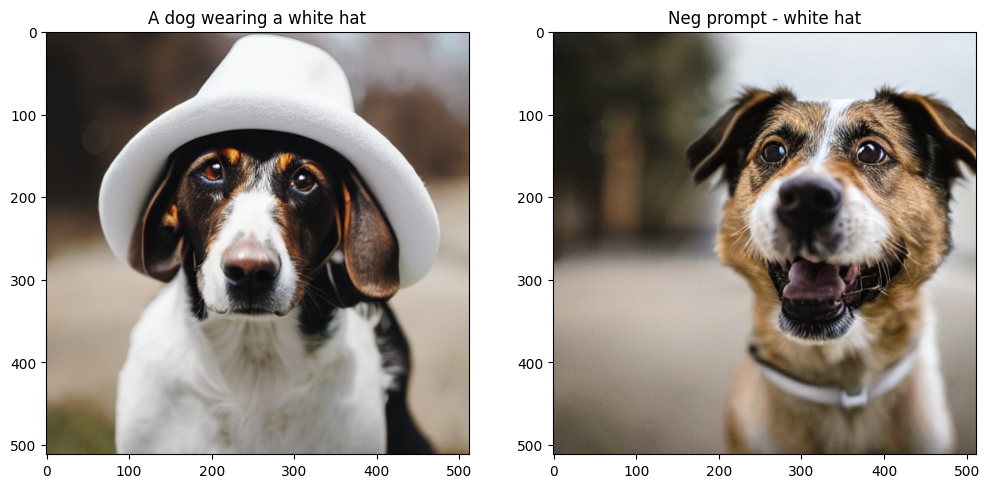

In [8]:
#生成两张图片看看效果

## Image without neg prompt
images = [None, None]
images[0] = prompt_2_img(prompts = ["A dog wearing a white hat"], neg_prompts=[""],steps=50, save_int=False)[0]
images[1] = prompt_2_img(prompts = ["A dog wearing a white hat"], neg_prompts=["White hat"],steps=50, save_int=False)[0]
    
## Plotting side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for c, img in enumerate(images): 
    axs[c].imshow(img)
    if c == 0 : axs[c].set_title(f"A dog wearing a white hat")
    else: axs[c].set_title(f"Neg prompt - white hat")

/tmp/ipykernel_14157/1185465686.py:23: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))


  0%|          | 0/50 [00:00<?, ?it/s]

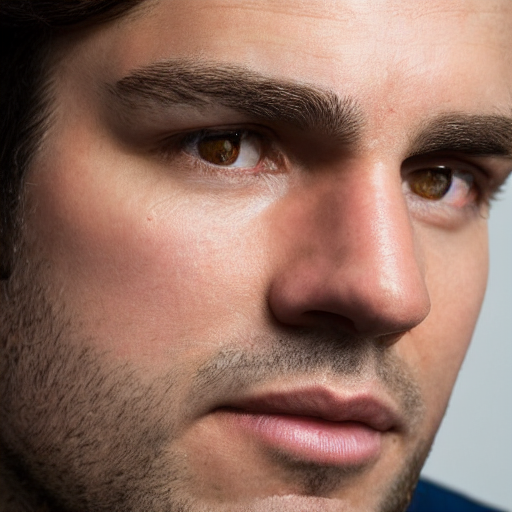

In [9]:
#通过负文本生成高质量图片

prompt = ['Close-up photography of the face of a 30 years old man with brown eyes, (by Alyssa Monks:1.1), by Joseph Lorusso, by Lilia Alvarado, beautiful lighting, sharp focus, 8k, high res, (pores:0.1), (sweaty:0.8), Masterpiece, Nikon Z9, Award - winning photograph']
neg_prompt = ['lowres, signs, memes, labels, text, food, text, error, mutant, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry, made by children, caricature, ugly, boring, sketch, lacklustre, repetitive, cropped, (long neck), facebook, youtube, body horror, out of frame, mutilated, tiled, frame, border, porcelain skin, doll like, doll']
images = prompt_2_img(prompts = prompt, neg_prompts=neg_prompt, steps=50, save_int=False)
images[0]

### Variation 2: Image to Image pipeline

In [10]:
# 一个简单的想法，就是将图像加噪到一定程度，然后开始去噪，实现image2image
# 感觉类似SDEit，只不过把ddpm换成了Stable Diffusion

def prompt_2_img_i2i(prompts, init_img, neg_prompts=None, g=7.5, seed=100, strength =0.8, steps=50, dim=512, save_int=False):
    """
    Diffusion process to convert prompt to image
    """
    # Converting textual prompts to embedding
    text = text_enc(prompt) 
    
    # Adding an unconditional prompt , helps in the generation process
    if not neg_prompts: uncond =  text_enc([""], text.shape[1])
    else: uncond =  text_enc(neg_prompt, text.shape[1])
    emb = torch.cat([uncond, text])
    
    # Setting the seed
    if seed: torch.manual_seed(seed)
    
    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)
    
    # Convert the seed image to latent
    init_latents = pil_to_latents(init_img)
    
    # Figuring initial time step based on strength
    init_timestep = int(steps * strength) 
    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps], device="cuda")
    
    # Adding noise to the latents 
    noise = torch.randn(init_latents.shape, generator=None, device="cuda", dtype=init_latents.dtype)
    init_latents = scheduler.add_noise(init_latents, noise, timesteps)
    latents = init_latents
    
    # Computing the timestep to start the diffusion loop
    t_start = max(steps - init_timestep, 0)
    timesteps = scheduler.timesteps[t_start:].to("cuda")
    
    # Iterating through defined steps
    for i,ts in enumerate(tqdm(timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        
        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            
        # Performing Guidance
        pred = u + g*(t-u)
        
        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample
        
        # Saving intermediate images
        if save_int: 
            if not os.path.exists(f'./steps'):
                os.mkdir(f'./steps')
            latents_to_pil(latents)[0].save(f'steps/{i:04}.jpeg')
            
    # Returning the latent representation to output an image of 3x512x512
    return latents_to_pil(latents)

  0%|          | 0/40 [00:00<?, ?it/s]

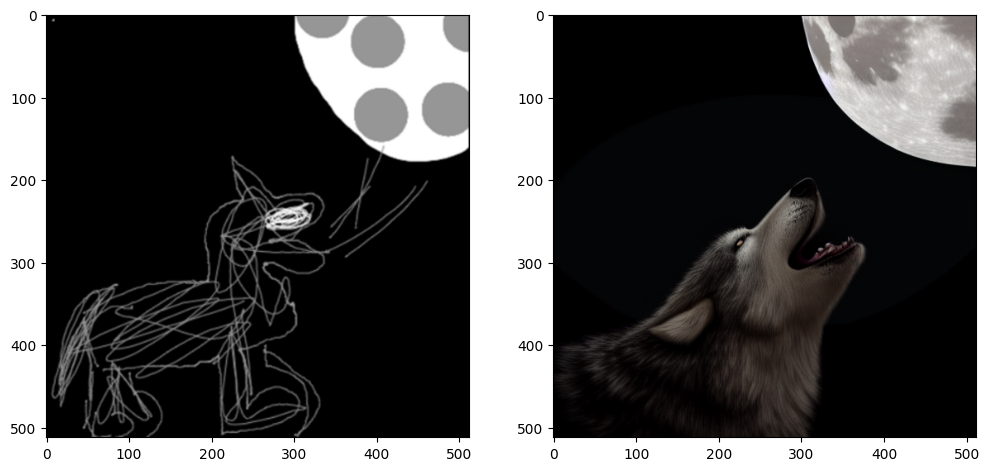

In [15]:
# p = FastDownload().download('https://s3.amazonaws.com/moonup/production/uploads/1664665907257-noauth.png')
# image = Image.open(p).convert('RGB').resize((512,512))
image = load_image('image/2.png')
prompt = ["Wolf howling at the moon, photorealistic 4K"]
images = prompt_2_img_i2i(prompts = prompt, init_img = image)

## Plotting side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(image)
axs[1].imshow(images[0])